In [1]:
from pylab import * 
import iris
import iris.plot as iplt
import cartopy.crs as ccrs
import netCDF4
import datetime as dt

In [22]:
year = 2005
start = dt.datetime(year,1,1,0,0,0)
stop = dt.datetime(year,12,31,18,0,0)
bbox = [-77.+360., -63.+360., 34., 46.]   # [lon_min lon_max lat_min lat_max]

In [3]:
# CFSR NOMADS OPeNDAP URL
url='http://nomads.ncdc.noaa.gov/thredds/dodsC/modeldata/cmd_ocnh/%4.4d/%4.4d01/%4.4d0101/ocnh01.gdas.%4.4d010100.grb2' % (year,year,year,year)
print url

http://nomads.ncdc.noaa.gov/thredds/dodsC/modeldata/cmd_ocnh/2005/200501/20050101/ocnh01.gdas.2005010100.grb2


In [4]:
# specify name of output file that will be created
ofile = '/usgs/data2/rsignell/models/ncep/CFSR/cfsr_%4.4d.nc' % year
print ofile

/usgs/data2/rsignell/models/ncep/CFSR/cfsr_2005.nc


In [5]:
cubes = iris.load(url)

In [6]:
print cubes

0: Temperature @ surface / (K)         (time: 1; latitude: 360; longitude: 720)
1: Tropical_Cyclone_Heat_Potential @ ocean_surface_and_26C_isothermal / (J m-2 K) (time: 1; latitude: 360; longitude: 720)
2: Evaporation_-_Precipitation @ surface / (cm/day) (time: 1; latitude: 360; longitude: 720)
3: Vertical_velocity_geometric @ depth_below_sea / (m s-1) (time: 1; Depth below sea level: 40; latitude: 360; longitude: 720)
4: Potential_temperature @ depth_below_sea / (K) (time: 1; Depth below sea level: 40; latitude: 360; longitude: 720)
5: Geometric_Depth_Below_Sea_Surface @ ocean_isotherm / (m) (time: 1; Ocean isotherm level: 1; latitude: 360; longitude: 720)
6: U-component_of_ice_drift @ surface / (m s-1) (time: 1; latitude: 360; longitude: 720)
7: Geometric_Depth_Below_Sea_Surface @ bottom_of_ocean_isothermal / (m) (time: 1; Bottom of ocean isothermal layer: 1; latitude: 360; longitude: 720)
8: U-component_of_current @ depth_below_sea / (m s-1) (time: 1; Depth below sea level: 40; lati

In [7]:
var_name = 'Potential_temperature'
cube = cubes[where([cube.var_name==var_name for cube in cubes])[0]]
slice = cube.extract(iris.Constraint(longitude=lambda cell: bbox[0]+360. < cell < bbox[1]+360.,
                                     latitude=lambda cell: bbox[2] < cell < bbox[3]))
shape(slice)

(1, 40, 24, 28)

In [8]:
# convert to degC
slice.convert_units('degC')

In [9]:
print slice

Potential_temperature @ depth_below_sea / (degC) (time: 1; Depth below sea level: 40; latitude: 24; longitude: 28)
     Dimension coordinates:
          time                                        x                         -             -              -
          Depth below sea level                       -                         x             -              -
          latitude                                    -                         -             x              -
          longitude                                   -                         -             -              x
     Attributes:
          Conventions: CF-1.0
          DODS.strlen: 0
          GRIB_VectorComponentFlag: easterlyNortherlyRelative
          GRIB_level_type: 160
          GRIB_param_category: Temperature
          GRIB_param_discipline: Meteorological_products
          GRIB_param_id: [2 0 0 2]
          GRIB_param_name: Potential_temperature
          GRIB_product_definition_type: Average, accumulation, e

In [10]:
# select surface layer at 1st time step for a test plot
slice2d=slice[0,-1,:,:]
shape(slice2d)

(24, 28)

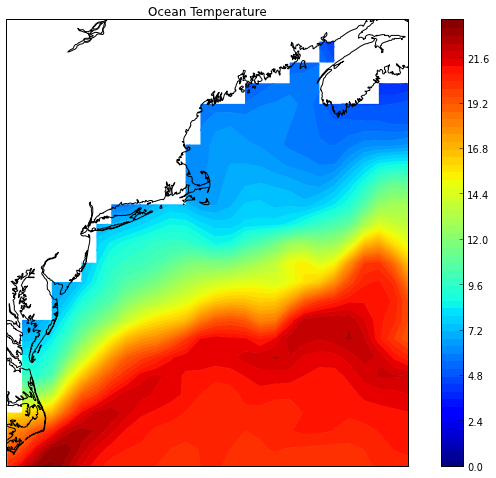

In [11]:
figure(figsize=(12,8))

# set the projection
ax1 = plt.axes(projection=ccrs.Mercator())

# color filled contour plot
h = iplt.contourf(slice2d,64)

# add coastlines, colorbar and title
plt.gca().coastlines(resolution='10m')
colorbar(h,orientation='vertical');
title('Ocean Temperature');

In [12]:
iris.save(slice,ofile)

In [30]:
nci = netCDF4.Dataset(url)
lon = nci.variables['lon'][:]
lat = nci.variables['lat'][:]
bi=(lon>=bbox[0])&(lon<=bbox[1])
bj=(lat>=bbox[2])&(lat<=bbox[3])
nci.close()

In [31]:
origin = dt.datetime(1900,1,1,0,0,0)
nsteps = int((stop - start).total_seconds()/3600/6)  # 6 hour time steps
print nsteps

nc = netCDF4.Dataset(ofile,'r+')
nc.variables['time'].units = 'hours since 1900-01-01T00:00:00Z'

for i in range(nsteps):
    dtime = start + dt.timedelta(hours=(6*i))
    dhours=(dtime - origin).total_seconds()/3600.
    url='http://nomads.ncdc.noaa.gov/thredds/dodsC/modeldata/\
cmd_ocnh/%4.4d/%4.4d%2.2d/%4.4d%2.2d%2.2d/ocnh01.gdas.%4.4d%2.2d%2.2d%2.2d.grb2' \
    % (dtime.year,
       dtime.year,dtime.month,
       dtime.year,dtime.month,dtime.day,
       dtime.year,dtime.month,dtime.day,dtime.hour)
    print '%5.2f percent complete in %5.3f hours' % (i*100./nsteps, (time()-time0)/3600.)
    nci = netCDF4.Dataset(url)
    data = nci.variables[var_name][:,:,bj,bi]
    nci.close()
    # hack here to convert Kelvin to Celcius since we are using NetCDF4
    nc.variables[var_name][i,:,:,:]= data - 273.15
    nc.variables['time'][i] = int(dhours)

1459
http://nomads.ncdc.noaa.gov/thredds/dodsC/modeldata/cmd_ocnh/2005/200501/20050101/ocnh01.gdas.2005010100.grb2
http://nomads.ncdc.noaa.gov/thredds/dodsC/modeldata/cmd_ocnh/2005/200501/20050101/ocnh01.gdas.2005010106.grb2
http://nomads.ncdc.noaa.gov/thredds/dodsC/modeldata/cmd_ocnh/2005/200501/20050101/ocnh01.gdas.2005010112.grb2
http://nomads.ncdc.noaa.gov/thredds/dodsC/modeldata/cmd_ocnh/2005/200501/20050101/ocnh01.gdas.2005010118.grb2
http://nomads.ncdc.noaa.gov/thredds/dodsC/modeldata/cmd_ocnh/2005/200501/20050102/ocnh01.gdas.2005010200.grb2
http://nomads.ncdc.noaa.gov/thredds/dodsC/modeldata/cmd_ocnh/2005/200501/20050102/ocnh01.gdas.2005010206.grb2
http://nomads.ncdc.noaa.gov/thredds/dodsC/modeldata/cmd_ocnh/2005/200501/20050102/ocnh01.gdas.2005010212.grb2
http://nomads.ncdc.noaa.gov/thredds/dodsC/modeldata/cmd_ocnh/2005/200501/20050102/ocnh01.gdas.2005010218.grb2

KeyboardInterrupt: 

In [ ]:
nc.close()

In [ ]:
# check file we created
cubes = iris.load(ofile)
print cubes[0]